# Actor Critic domain adaptation of pre-trained agents for modified CartPole environments

In [1]:
import os, sys
from datetime import date

import numpy as np
import torch
import torch.optim as optim
import random
import gym
import matplotlib.pyplot as plt
from copy import deepcopy
import torch.nn as nn
import torch.nn.functional as F

from IPython import display
import matplotlib
import matplotlib.pyplot as plt

# script_dir = os.path.dirname( __file__ )
# mymodule_dir = os.path.join( script_dir, '..', 'alpha', 'beta' )
# sys.path.append( script_dir )

import site
site.addsitedir('../src/')

from dsnn import RSTDPNet
from model import DSNN

%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
dtype = torch.float
print(device)

cuda:0


In [3]:
# Environment specific parameters
env_name = 'CartPole-v0'
max_reward = 500
max_steps = 500

n_evaluations = 20
rstdp_episodes = 250

In [4]:
# Create environments
original_env = gym.make(env_name) #, render_mode="rgb_array")

/home3/p306982/.conda/envs/drl/lib/python3.8/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [5]:
class Policy(nn.Module):
    """
    implements both actor and critic in one model
    """
    def __init__(self):
        super(Policy, self).__init__()
        self.affine1 = nn.Linear(4, 128)

        # actor's layer
        self.action_head = nn.Linear(128, 2)

        # critic's layer
        self.value_head = nn.Linear(128, 1)

        # action & reward buffer
        self.saved_actions = []
        self.rewards = []

    def forward(self, x):
        """
        forward of both actor and critic
        """
        x = F.relu(self.affine1(x))

        # actor: choses action to take from state s_t
        # by returning probability of each action
        action_prob = F.softmax(self.action_head(x), dim=-1)

        # critic: evaluates being in the state s_t
        state_values = self.value_head(x)

        # return values for both actor and critic as a tuple of 2 values:
        # 1. a list with the probability of each action over the action space
        # 2. the value from state s_t
        return action_prob, state_values

    def get_hidden(self, x):
        x = F.relu(self.affine1(x))

        return (x) 

In [6]:
model = Policy()

pre_trained_model = torch.load("../CartPole-v0/ac_results/ac_model")

model.affine1 = pre_trained_model.affine1
model.affine1.requires_grad = False
model.action_head = pre_trained_model.action_head
model.action_head.requires_grad = False
model.value_head = pre_trained_model.value_head
model.value_head.requires_grad = False

In [7]:
# Helper for printing
eraser = '\b \b'

### Evaluate pre-trained models on original environment

In [8]:
evaluation_seeds = np.load('../seeds/evaluation_seeds.npy')

In [9]:
def evaluate_policy(policy_net, env, n_evaluations, seeds, render=False, gym=True): 
    eval_rewards = []
    for i in range(n_evaluations):
        if gym:
            env.seed(int(seeds[i]))
            state = env.reset() #seed = int(seeds[i]))
        else:
            env.seed()
            state, _ = env.reset(seed = int(seeds[i]))
        if render:
            # env.render()
            img = plt.imshow(env.render(mode='rgb_array'))
        # env.render()
        reward = 0
        done = False

        while not done:
            if render:
                img.set_data(env.render(mode='rgb_array')) # just update the data
                display.display(plt.gcf())
                display.clear_output(wait=True)
            inputs = torch.from_numpy(state).float().cuda()
            out, _ = policy_net(inputs)
            action = torch.argmax(out)
            if gym:
                state, r, done, _ = env.step(action.item())
            else:
                state, r, done, truncated, info = env.step(action.item())
            reward += r
        eval_rewards.append(reward)

    return eval_rewards

In [10]:
n_evaluations = 20

In [11]:
original_eval_rewards = []

policy_net = model.cuda()
rewards = evaluate_policy(policy_net, original_env, n_evaluations, evaluation_seeds)
# original_eval_rewards.append(rewards)
print(eraser*3 + 'Avg reward: {:7.2f}'.format(np.mean(rewards)))

Avg reward:  500.00


/home3/p306982/.conda/envs/drl/lib/python3.8/site-packages/gymnasium/envs/classic_control/cartpole.py:215: UserWarning: WARN: You are calling render method without specifying any render mode. You can specify the render_mode at initialization, e.g. gym.make("CartPole-v1", render_mode="rgb_array")
  gym.logger.warn(


TypeError: Image data of dtype object cannot be converted to float

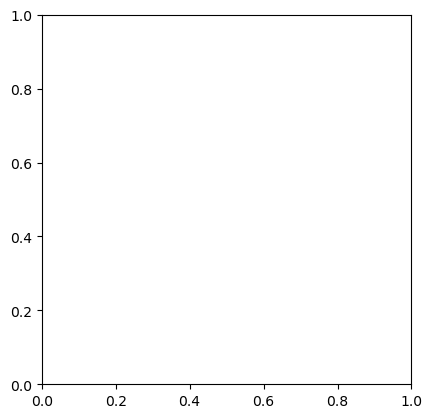

In [12]:
import gymnasium as gym
from IPython import display
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

env = gym.make('CartPole-v1')
env.reset()
img = plt.imshow(env.render()) # only call this once
for _ in range(100):
    img.set_data(env.render()) # just update the data
    display.display(plt.gcf())
    display.clear_output(wait=True)
    action = env.action_space.sample()
    env.step(action)

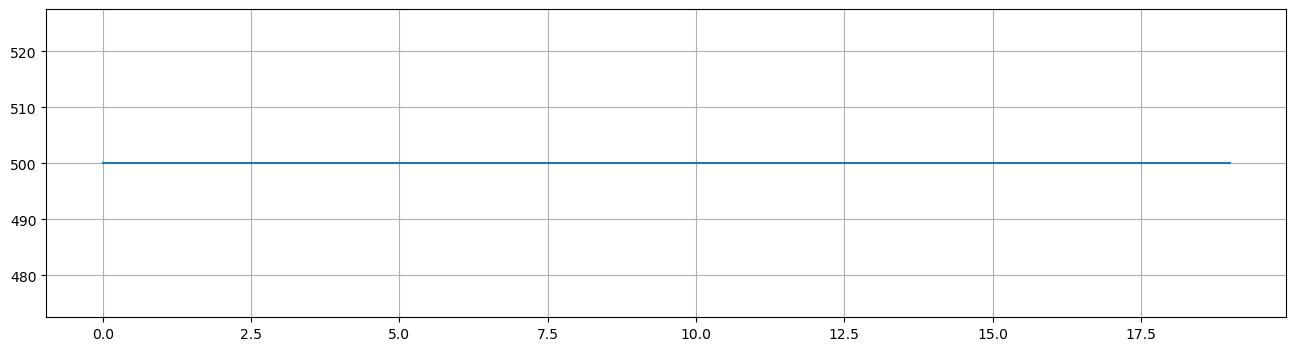

In [32]:
plt.figure(figsize=(16, 4))

plt.plot(rewards)

plt.grid()
plt.show()

### Evaluate pre-trained models on modified environment

In [56]:
modified_env = gym.make(env_name) #, render_mode="rgb_array")
modified_env.unwrapped.length *= 3

In [57]:
policy_net = model.cuda()
rewards = evaluate_policy(policy_net, modified_env, n_evaluations, evaluation_seeds)
# original_eval_rewards.append(rewards)
print(eraser*3 + 'Avg reward: {:7.2f}'.format(np.mean(rewards)))

Avg reward:   15.25


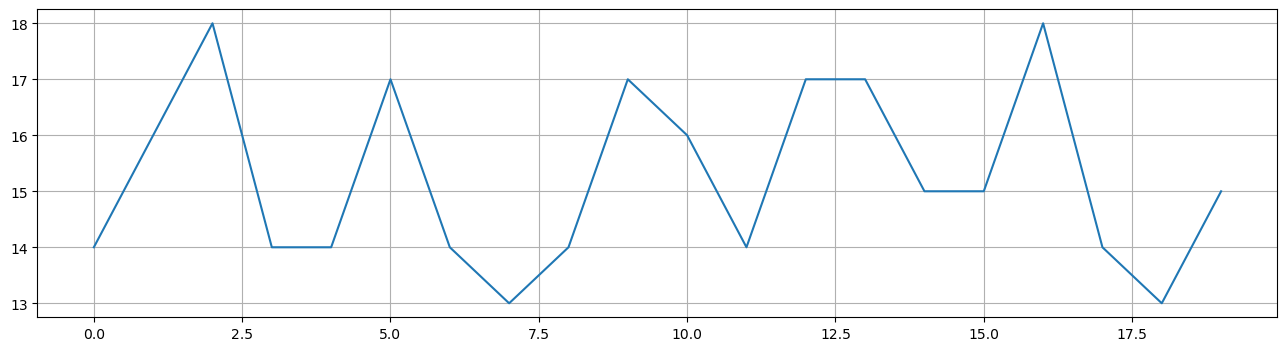

In [58]:
plt.figure(figsize=(16, 4))

plt.plot(rewards)

plt.grid()
plt.show()

### Temporal Difference Delta Rule Adaptation

In [104]:
modified_env = gym.make(env_name)
modified_env.unwrapped.length *= 4

In [9]:
# Hyperparameters
n_evaluations = 1
batch_size = 1
discount_factor = 0.999
eps_start = 1.0
eps_end = 0.05
eps_decay = 0.999
update_every = 4
target_update_frequency = 100
learning_rate = 0.001
replay_memory_size = 4*10**4
tau = 1e-3

In [10]:
pre_trained_model = torch.load("../CartPole-v0/ac_results/ac_model")

In [11]:
def init_model():

    pre_trained_model = torch.load("../CartPole-v0/ac_results/ac_model")
    new_model = Policy()

    new_model.affine1 = pre_trained_model.affine1
    new_model.affine1.requires_grad = False
    new_model.action_head = pre_trained_model.action_head
    new_model.action_head.requires_grad = False
    new_model.value_head = pre_trained_model.value_head
    new_model.value_head.requires_grad = False

    return new_model

In [12]:
rstdp_seeds = np.load('../seeds/rstdp_training_seeds.npy')
architecture = [4,128,2]

In [13]:
model = init_model()
model.value_head.requires_grad

False

In [128]:
def test(learning_rate=0.0001, num_episodes=50, trace_decay=0.7, gamma=0.99, value_upd= True, hidden_upd = False, DEBUG=False, one_ep=False):

    model = init_model().cuda()
    # print(model.value_head.weight[0])


    DEBUG=DEBUG
    td_learning_rate = learning_rate
    num_episodes = num_episodes
    if DEBUG:
        num_episodes = 1
    gamma = gamma
    trace_decay = trace_decay

    modified_env._max_episode_steps = max_steps

    rewards = []
    time_rewards = []
    hidden_traces = []
    action_traces = []
    hidden_act = []
    values = []
    

    for i_episode in range(num_episodes):

        if one_ep: 
            model = init_model().cuda()
        modified_env.seed(int(rstdp_seeds[i_episode]))
        
        state = modified_env.reset()
        total_reward = 0
        hidden_trace = torch.zeros((batch_size, architecture[-2]), device=device)
        action_trace = torch.zeros((batch_size, architecture[-1]), device=device)
        value = -abs(state[2]/0.2)
        td_errors = []
        td_error_MA = 0
        value_update = torch.zeros((architecture[-2], 1), device=device)
        action_update = torch.zeros((architecture[-2], architecture[-1]), device=device)
        for t in range(max_steps):
            if DEBUG:
                print('t', t)
            with torch.no_grad():
                
                state = np.resize(state, (batch_size, state.shape[0]))
                inputs = torch.from_numpy(state).float().to(device)


                ### INFERENCE ###

                action_prob, new_value = model.forward(inputs)
                action = torch.argmax(action_prob)
                state, time_reward, done, _ = modified_env.step(action.cpu().numpy())
                reward = -abs(state[2]/0.2) # time_reward

                ### GET Weight UPDATE ###

                z = model.get_hidden(inputs)
                hidden_trace = trace_decay*hidden_trace + z

                action_oh = F.one_hot(action, num_classes=2)
                action_trace = trace_decay*action_trace + action_oh


                td_error = reward + gamma*new_value - value

                td_errors.append(td_error.cpu().numpy())
                td_error_MA = np.mean(td_errors[-11:])

                td_error = td_error - td_error_MA

                if value_upd:
                    value_learning_value = torch.einsum("bz,bv->zv", [hidden_trace, td_error])
                    model.value_head.weight.data += (td_learning_rate*value_learning_value).t()
                action_learning_value = torch.einsum("bz,ba->bza", [hidden_trace, action_trace])
                model.action_head.weight.data += (td_learning_rate*torch.einsum("bza,bv->za", [action_learning_value, td_error])).t()

                value = new_value
                if DEBUG:
                    print('DONE', done)
                    print('hidden_trace', torch.sum(hidden_trace))
                    print('action_trace', torch.sum(action_trace))
                    print('REWARD', reward)
                    print('VALUE', value)
                    print(torch.squeeze(value).cpu().numpy())
                    print('TD error', td_error)
                    print('Value update', value_learning_value[0])
                    print('Action update', action_learning_value)
                
                rewards.append(reward)
                # td_errors.append(torch.squeeze(td_error).cpu().numpy())
                hidden_traces.append(hidden_trace[0, 0].cpu().numpy())
                action_traces.append(action_trace[0, 0].cpu().numpy())
                hidden_act.append(z[:,0].cpu().numpy())
                values.append(torch.squeeze(value).cpu().numpy())

                total_reward += time_reward
                if done: ### DONE WHEN FULLY FALLING: LEAVE SOME WRONG ANGLE TO TRAIN ON
                    break

        if DEBUG:
            print(values)
            fig, axs = plt.subplots(6) 
            axs[0].plot(rewards[:100])
            axs[1].plot(td_errors[:100])
            axs[1].set_yscale('log')
            axs[2].plot(hidden_act[:100])
            axs[3].plot(hidden_traces[:100])
            axs[4].plot(action_traces[:100])
            axs[5].plot(values[:100])
            axs[5].set_yscale('log')

        # print(value_weights[0])
        # print('REWARD', total_reward)
        time_rewards.append(total_reward)
    plt.plot(time_rewards)
    return np.average(time_rewards)
    # plt.legend(str(learning_rate))
        # eval_rewards = evaluate_policy(policy_net, env, n_evaluations, evaluation_seeds)
        # avg_eval_reward = np.mean(eval_rewards)

In [34]:
model.value_head.weight

Parameter containing:
tensor([[ 4.2998e-02,  5.6653e-01, -8.9641e-02,  1.4522e-01,  7.6867e-02,
         -1.2400e-01, -1.4536e-01,  1.8997e-01, -2.3419e-02,  4.4277e-02,
         -1.2154e-01, -2.4863e-01,  2.4464e-02, -1.2495e-01,  1.7485e-01,
         -3.5029e-01,  2.0549e-01,  5.6322e-02,  2.4249e-03, -3.7381e-02,
          2.5410e-01,  6.0952e-02,  5.6410e-02, -4.2912e-01, -1.6689e-01,
          2.7489e-01, -2.7312e-01,  2.0608e-01, -3.0858e-01,  2.7944e-01,
         -1.5920e-01,  6.9783e-03, -2.4371e-01,  8.1752e-02,  1.7941e-01,
          3.0410e-03,  2.3120e-01,  1.6237e-01,  1.8527e-01,  3.8749e-02,
          9.4014e-02,  5.1119e-02,  4.0491e-02, -1.7832e-01, -1.5264e-02,
          5.7467e-02, -8.1482e-02,  4.6839e-01, -2.0129e-01, -8.7364e-01,
         -8.3995e-04,  1.2093e-01, -2.2014e-02,  2.0239e-01, -1.5928e-01,
          1.2938e-01, -3.1791e-01,  3.6021e-02, -9.4143e-02, -2.8824e-01,
          1.4035e-02,  1.4128e-01,  7.0626e-01, -1.2838e-01,  5.2102e-02,
          1.8483

17.54

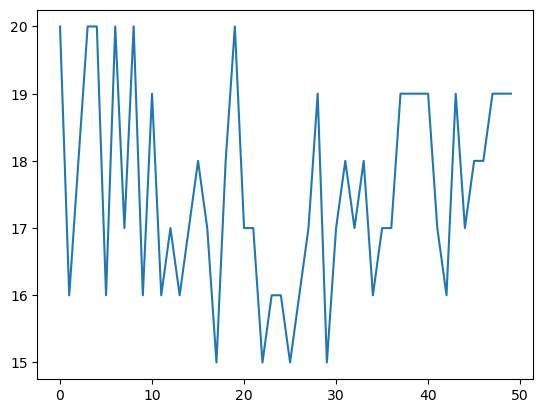

In [105]:
test(0)

54.7

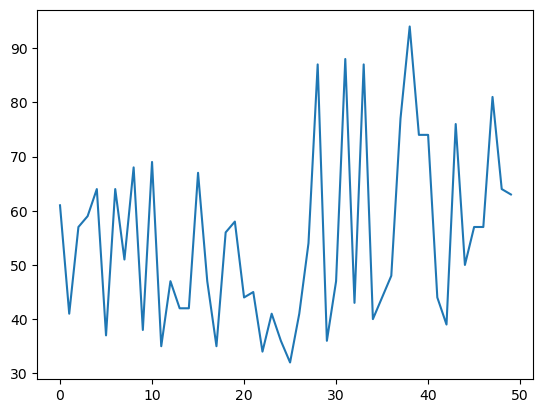

In [141]:
test(2, gamma=0.9, trace_decay=0.6, one_ep=True)

1.0 0.7
21.4
1.0 0.7999999999999999
23.0
1.0 0.8999999999999999
32.8
1.0 0.9999999999999999
46.4
2.23606797749979 0.7
25.4
2.23606797749979 0.7999999999999999
29.4
2.23606797749979 0.8999999999999999
44.0
2.23606797749979 0.9999999999999999
48.4
5.0 0.7
32.0
5.0 0.7999999999999999
53.8
5.0 0.8999999999999999
49.6
5.0 0.9999999999999999
48.2
11.18033988749895 0.7
34.8
11.18033988749895 0.7999999999999999
56.2
11.18033988749895 0.8999999999999999
47.6
11.18033988749895 0.9999999999999999
48.6
25.0 0.7
47.2
25.0 0.7999999999999999
47.2
25.0 0.8999999999999999
45.8
25.0 0.9999999999999999
48.4


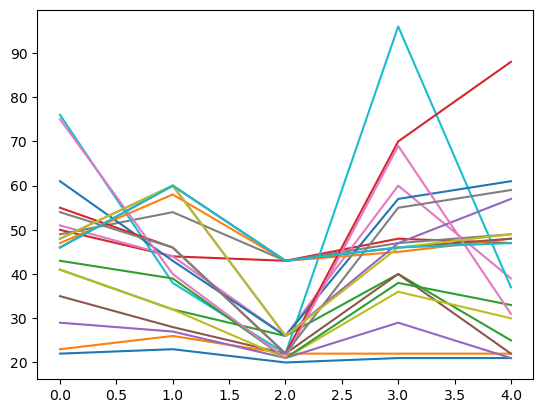

In [61]:
best_perf = 10
for lr in np.geomspace(1, 25, num=5):   
    for tr in np.arange(0.7,1, 0.1):
        print(lr, tr) 
        perf = test(lr, num_episodes=5, trace_decay=tr, one_ep=True)
        print(perf)
        if perf > best_perf:
            best_perf = perf
            best_config = (lr, tr)

0.05 0.5 0.9
18.2
0.05 0.5 0.92
18.2
0.05 0.5 0.9400000000000001
18.0
0.05 0.5 0.9600000000000001
18.0
0.05 0.5 0.9800000000000001
17.8
0.05 0.52 0.9
18.4
0.05 0.52 0.92
18.2
0.05 0.52 0.9400000000000001
18.0
0.05 0.52 0.9600000000000001
18.0
0.05 0.52 0.9800000000000001
18.0
0.05 0.54 0.9
18.8
0.05 0.54 0.92
18.2
0.05 0.54 0.9400000000000001
18.2
0.05 0.54 0.9600000000000001
18.0
0.05 0.54 0.9800000000000001
18.0
0.05 0.56 0.9
18.8
0.05 0.56 0.92
18.6
0.05 0.56 0.9400000000000001
18.2
0.05 0.56 0.9600000000000001
18.0
0.05 0.56 0.9800000000000001
18.0
0.05 0.5800000000000001 0.9
18.8
0.05 0.5800000000000001 0.92
18.8
0.05 0.5800000000000001 0.9400000000000001
18.2
0.05 0.5800000000000001 0.9600000000000001
18.2
0.05 0.5800000000000001 0.9800000000000001
18.0
0.05 0.6000000000000001 0.9
18.8
0.05 0.6000000000000001 0.92
18.8
0.05 0.6000000000000001 0.9400000000000001
18.4
0.05 0.6000000000000001 0.9600000000000001
18.2
0.05 0.6000000000000001 0.9800000000000001
18.0
0.05 0.620000000000

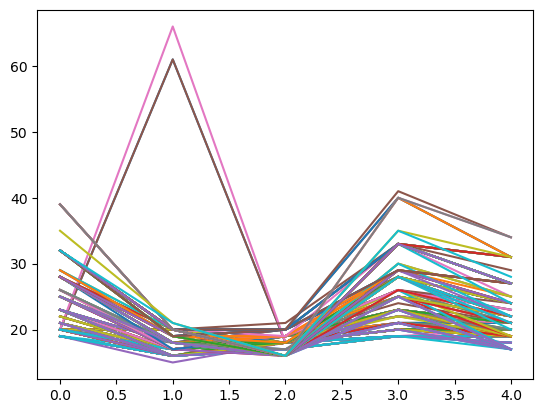

In [49]:
best_perf = 10
for lr in np.geomspace(0.05, 0.3, num=5):   
    for tr in np.arange(0.5,0.7, 0.02):
        for gamma in np.arange(0.9,1, 0.02):
            print(lr, tr, gamma) 
            perf = test(lr, num_episodes=5, trace_decay=tr, gamma=gamma, one_ep=True)
            print(perf)
            if perf > best_perf:
                best_perf = perf
                best_config = (lr, tr, gamma)


In [62]:
print(best_config)
print(best_perf)

(11.18033988749895, 0.7999999999999999)
56.2


tensor([ 4.2998e-02,  5.6653e-01, -8.9641e-02,  1.4522e-01,  7.6867e-02,
        -1.2400e-01, -1.4536e-01,  1.8997e-01, -2.3419e-02,  4.4277e-02,
        -1.2154e-01, -2.4863e-01,  2.4464e-02, -1.2495e-01,  1.7485e-01,
        -3.5029e-01,  2.0549e-01,  5.6322e-02,  2.4249e-03, -3.7381e-02,
         2.5410e-01,  6.0952e-02,  5.6410e-02, -4.2912e-01, -1.6689e-01,
         2.7489e-01, -2.7312e-01,  2.0608e-01, -3.0858e-01,  2.7944e-01,
        -1.5920e-01,  6.9783e-03, -2.4371e-01,  8.1752e-02,  1.7941e-01,
         3.0410e-03,  2.3120e-01,  1.6237e-01,  1.8527e-01,  3.8749e-02,
         9.4014e-02,  5.1119e-02,  4.0491e-02, -1.7832e-01, -1.5264e-02,
         5.7467e-02, -8.1482e-02,  4.6839e-01, -2.0129e-01, -8.7364e-01,
        -8.3995e-04,  1.2093e-01, -2.2014e-02,  2.0239e-01, -1.5928e-01,
         1.2938e-01, -3.1791e-01,  3.6021e-02, -9.4143e-02, -2.8824e-01,
         1.4035e-02,  1.4128e-01,  7.0626e-01, -1.2838e-01,  5.2102e-02,
         1.8483e-01,  5.7234e-02,  1.2615e-01,  1.1

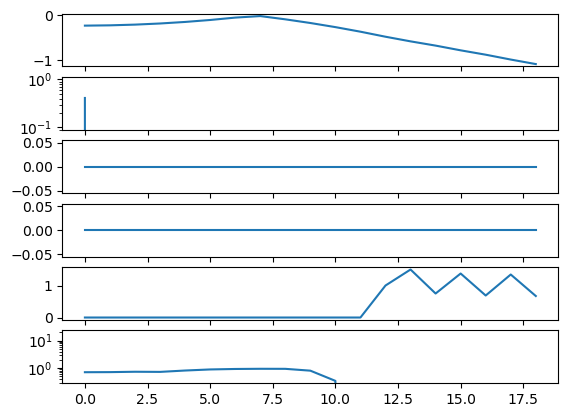

In [19]:
test(0.05, 1, True)

57.5


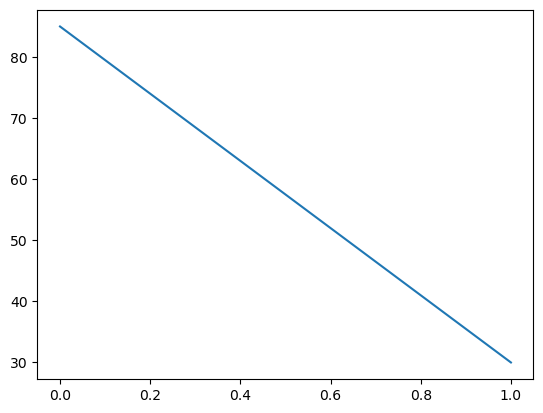

In [123]:
test(0.001, 2)

In [105]:
print(full_net.value.weights)

Parameter containing:
tensor([[-5.8028e-02],
        [ 1.3876e-02],
        [-4.6794e-02],
        [-2.1160e-02],
        [-6.5274e-03],
        [-1.1158e-02],
        [ 1.4258e-02],
        [ 2.4070e-02],
        [-8.7123e-03],
        [-2.3021e-02],
        [ 5.5939e-05],
        [-2.3316e-02],
        [-1.6715e-03],
        [ 7.4907e-03],
        [-2.9022e-02],
        [-3.2648e-02],
        [-2.5544e-02],
        [-1.0584e-02],
        [-2.3084e-02],
        [-2.3914e-02],
        [ 1.7426e-02],
        [-4.5012e-02],
        [-1.1314e-02],
        [-3.1790e-02],
        [ 2.3100e-03],
        [-1.1077e-02],
        [-2.4732e-02],
        [-7.1452e-03],
        [ 7.1035e-04],
        [ 1.1985e-03],
        [-1.4523e-02],
        [ 1.2611e-02],
        [-2.2059e-03],
        [-2.2610e-02],
        [-1.2019e-04],
        [-9.5961e-03],
        [ 1.2459e-02],
        [ 2.0186e-03],
        [-1.2745e-02],
        [-2.5560e-03],
        [ 3.1817e-02],
        [-1.2964e-02],
        [-1.

In [59]:
%load_ext autoreload
%autoreload 2
from model import DSNN

lr = learning_rate
num_episodes = rstdp_episodes
env = modified_env

hidden_net = DSNN(architecture[:-1], 0, alpha, beta, weight_scale, batch_size, threshold,
                      simulation_time, learning_rate, spk_out_sum=True)
weight_seed0 = weights[0]
hidden_net.load_weights(weight_seed0[0][:-1]) #Only hidden network
actor_weights = weight_seed0[0][-1]
value_weights = torch.empty((architecture[-2], architecture[-1]), device=device, dtype=torch.float, requires_grad=False)
torch.nn.init.normal_(value_weights, mean=0.0, std=weight_scale/np.sqrt(architecture[-1]))


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


tensor([[ 1.7989, -0.5065],
        [-0.3489,  0.0896],
        [ 0.0717, -0.2853],
        [ 0.6380,  0.5727],
        [-0.4868,  0.0970],
        [ 0.7338,  0.0654],
        [-0.2653, -0.0642],
        [ 1.4594, -1.2844],
        [-0.1922,  0.1988],
        [-0.7353,  0.5491],
        [ 0.6233,  0.0314],
        [-1.0515,  0.8015],
        [ 0.9382, -0.8921],
        [ 0.6718, -0.4637],
        [ 0.6433, -0.4448],
        [-0.4658,  1.4716],
        [ 1.0006, -0.2186],
        [-0.1453,  1.4540],
        [-0.0347, -0.4498],
        [-0.3790, -0.0926],
        [-0.2083,  0.8680],
        [ 0.7459,  0.2528],
        [ 1.1581, -0.1634],
        [ 0.5574, -0.0571],
        [-0.2775,  0.8962],
        [ 0.7368, -0.3497],
        [-0.8229,  1.1130],
        [ 0.5032,  0.4316],
        [ 0.9088, -0.4619],
        [ 0.7899, -0.7118],
        [ 0.9130,  1.1334],
        [ 0.0942,  0.7568],
        [-0.7892, -0.5937],
        [-2.5937,  0.5790],
        [ 0.0887, -0.5439],
        [ 0.1097, -0

In [36]:
for t in range(max_steps):
    state = env.reset()
    print(state)

[-0.04164862  0.01279319 -0.03198613 -0.04354728]
[-0.0338814  -0.02272913 -0.04876121 -0.00927737]
[ 0.00907432 -0.04978249  0.01365784  0.00348372]
[-0.00241364  0.02709097  0.0491919  -0.03837302]
[ 0.02797048 -0.0213679  -0.03647558 -0.0377784 ]
[ 0.01954947 -0.0149603  -0.01214877 -0.02309371]
[-0.02227033  0.01900424  0.0299077   0.01418891]
[ 0.02994294 -0.03585773  0.03368881 -0.0368263 ]
[ 0.04452436  0.02773551  0.04460242 -0.01610783]
[-0.04779275 -0.04554034 -0.01462114  0.0363768 ]
[ 0.03813785  0.02835837 -0.04054477  0.04001045]
[-0.0106544  -0.03896252 -0.00124269  0.02718378]
[-0.02351293 -0.04978914 -0.01218092 -0.04346545]
[-0.03642882  0.00428937 -0.0188272  -0.04750161]
[-0.00549906 -0.0019812  -0.03596947  0.03843012]
[-0.0028367   0.00878644 -0.01685082 -0.04626367]
[-0.01287867 -0.02737688  0.04976248  0.03821711]
[ 0.04473881  0.04417277 -0.04542288  0.00224569]
[-0.00281019  0.04253444  0.02623526  0.01103189]
[-0.0362462  -0.03594795 -0.02588833 -0.01308069]


In [55]:
print(max_steps)
range(max_steps)

200


range(0, 200)

In [60]:
from dsnn import transform_state

DEBUG=True
if DEBUG:
    num_episodes = 2
gamma = 0.9
trace_decay = 0.7
td_learning_rate = 0

env._max_episode_steps = max_steps

best_reward = -np.inf
best_episode = -1
best_weights = None

rewards = []

for i_episode in range(num_episodes):
    env.seed(int(rstdp_seeds[i_episode]))
    
    e_trace = None
    
    state = env.reset()
    total_reward = 0
    hidden_trace = torch.zeros((batch_size, architecture[-2]), device=device)
    action_trace = torch.zeros((batch_size, architecture[-1]), device=device)
    value = 0
    for t in range(max_steps):
        if DEBUG:
            print('t', t)
        inputs = torch.from_numpy(state).float()
        inputs = transform_state(inputs)
        inputs = inputs.unsqueeze(dim=0).to(device)

        z_spkcount = hidden_net.forward(inputs)
        # if DEBUG:
        #     print(torch.sum(z_spkcount))
        hidden_act = z_spkcount/simulation_time

        new_value = torch.einsum("bz,zv->bv", [hidden_act, value_weights])
        action_logits = torch.einsum("bz,za->ba", [hidden_act, actor_weights])

        # Action definition + application
        action = torch.argmax(action_logits)
        action_oh = F.one_hot(action, num_classes=actor_weights.size()[-1])

        state, time_reward, done, _ = env.step(action.cpu().numpy())
        reward = -abs(state[2]/0.2)

        # TD Delta Update
        hidden_trace = trace_decay*hidden_trace + hidden_act
        action_trace = trace_decay*action_trace + action_oh



        td_error = reward + gamma*new_value - value

        value_learning_value = torch.einsum("bz,bv->zv", [hidden_trace, td_error])
        value_weights += td_learning_rate*value_learning_value
        action_learning_value = torch.einsum("bz,ba->bza", [hidden_trace, action_trace])
        actor_weights += td_learning_rate*torch.einsum("bza,bv->za", [action_learning_value, td_error])


        if DEBUG:
            print('DONE', done)
            print('hidden_trace', torch.sum(hidden_trace))
            print('action_trace', torch.sum(action_trace))
            print('REWARD', reward)
            print('VALUE', value)
            print('TD error', td_error)
            print('Value update', value_learning_value[0])
            print('Action update', action_learning_value)
        value = new_value

        total_reward += time_reward
        # if done: ### DONE WHEN FULLY FALLING: LEAVE SOME WRONG ANGLE TO TRAIN ON
        #     break

    # print(value_weights[0])
    print('REWARD', total_reward)
    rewards.append(total_reward)
    
    # eval_rewards = evaluate_policy(policy_net, env, n_evaluations, evaluation_seeds)
    # avg_eval_reward = np.mean(eval_rewards)

t 0
DONE False
hidden_trace tensor(2.7500, device='cuda:0')
action_trace tensor(1., device='cuda:0')
REWARD -0.22848079807033703
VALUE 0
TD error tensor([[ 0.2510, -2.9243]], device='cuda:0')
Value update tensor([0., -0.], device='cuda:0')
Action update tensor([[[0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.5000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000,

In [41]:
value_weights

tensor([[nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],


### Evaluate adapted models on modified environment

In [ ]:
adapted_eval_rewards = []

for i, w in enumerate(adapted_weights_collection):
    print('Run {:02d} ...'.format(i), end='')
    policy_net = RSTDPNet(alpha, beta, threshold, architecture, simulation_time, w,
                                  device=device, dtype=dtype)
    rewards = evaluate_policy(policy_net, modified_env, n_evaluations, evaluation_seeds)
    adapted_eval_rewards.append(rewards)
    print(eraser*3 + '-> Avg reward: {:7.2f}'.format(np.mean(rewards)))

In [ ]:
plt.figure(figsize=(16, 4))

for i, aer in enumerate(adapted_eval_rewards):
    plt.plot(aer, label='Run {:02d}'.format(i))

plt.legend()
plt.grid()
plt.show()